In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import datetime
from scipy import stats
import plotly.io as pio
pio.templates.default = "none"
from scipy.stats import ttest_rel, ttest_ind

In [5]:
dataset_path = '22subjects/STRESS'
stress_level_v1_path = 'Stress_Level_v1.csv'
stress_level_v2_path = 'Stress_Level_v2.csv'
subject_info_path = 'subject-info.csv'

# Stress
Self-Reported Stress Levels

### Load Data

In [6]:
stress_v1 = pd.read_csv(stress_level_v1_path, index_col=0)
stress_v2 = pd.read_csv(stress_level_v2_path, index_col=0)
subject_info = pd.read_csv(subject_info_path, index_col=0)

In [7]:
subject_info.head()

,Gender,Age,Height (cm),Weight (kg),Does physical activity regularly?,Protocol,Stress Inducement,Aerobic Exercise,Anaerobic Exercise
Info,,,,,,,,,
S01,m,21,192,84,Yes,V1,Yes,Yes,Yes****
S02,m,20,185,95,No,V1,Yes****,Yes,Yes
S03,m,20,175,62,Yes,V1,Yes,Yes***,Yes
S04,m,21,174,70,Yes,V1,Yes,Yes,Yes
S05,m,21,173,72,Yes,V1,Yes,Yes,Yes


In [8]:
stress_v1.head()

,Baseline,Stroop,First Rest,TMCT,Second Rest,Real Opinion,Opposite Opinion,Subtract
S01,3.0,4.5,4.0,4.0,5.5,6.0,7.0,7.0
S02,2.0,4.0,2.0,2.0,2.0,4.0,5.0,4.0
S03,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0
S04,3.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0
S05,1.0,2.0,1.0,4.0,1.0,2.0,2.0,3.0


In [9]:
stress_v2.head()

,Baseline,TMCT,First Rest,Real Opinion,Opposite Opinion,Second Rest,Subtract
f01,2.0,5.0,2.0,3.0,4.0,2.0,3.0
f02,3.0,5.0,1.0,2.0,3.0,2.0,3.0
f03,5.0,8.0,1.0,3.0,5.0,1.0,6.0
f04,2.0,4.0,3.0,3.0,4.0,1.0,4.0
f05,3.0,4.0,3.0,3.0,3.0,2.0,3.0


## Stressful vs Non-stressful Distributions

Stress-inducing protocols: 
- Stroop (V1)
- TMCT (V1 & V2)
- Real Opinion (V1 & V2)
- Opposite Opinion (V1 & V2)
- Subtract (V1 & V2)

Non stress-inducing protocols:
- Baseline (V1 & V2)
- First Rest (V1 & V2)
- Second Rest (V1 & V2)

In [10]:
def melt_stress(df):
    return df.reset_index().melt(
        id_vars="index",
        var_name="Protocol",
        value_name="Stress"
    ).rename(columns={"index":"Subject"})

v1_long = melt_stress(stress_v1)
v2_long = melt_stress(stress_v2)
v1_long["Subject Group"] = "V1"
v2_long["Subject Group"] = "V2"

all_stress = pd.concat([v1_long, v2_long], ignore_index=True)

stressful = ["Stroop", "TMCT", "Real Opinion", "Opposite Opinion", "Subtract"]
nonstressful = ["Baseline", "First Rest", "Second Rest"]

all_stress["Stress Inducing"] = all_stress["Protocol"].apply(
    lambda x: "Yes" if x in stressful else "No"
)

all_stress

,Subject,Protocol,Stress,Subject Group,Stress Inducing
0,S01,Baseline,3.0,V1,No
1,S02,Baseline,2.0,V1,No
2,S03,Baseline,3.0,V1,No
3,S04,Baseline,3.0,V1,No
4,S05,Baseline,1.0,V1,No
...,...,...,...,...,...
265,f14,Subtract,9.0,V2,Yes
266,f15,Subtract,5.0,V2,Yes
267,f16,Subtract,6.0,V2,Yes
268,f17,Subtract,6.0,V2,Yes


In [11]:
v1_means = stress_v1.mean()
v2_means = stress_v2.mean()

mean_df = pd.DataFrame({
    "V1": v1_means,
    "V2": v2_means
})


styler = mean_df.style.set_caption("Mean Stress Levels (Self-Reported)")
display(styler)

,V1,V2
Baseline,3.444444,3.277778
First Rest,3.222222,2.611111
Opposite Opinion,4.305556,4.166667
Real Opinion,4.138889,3.555556
Second Rest,3.666667,2.388889
Stroop,3.972222,nan
Subtract,4.527778,4.555556
TMCT,5.083333,6.388889


/Users/essiecheng/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


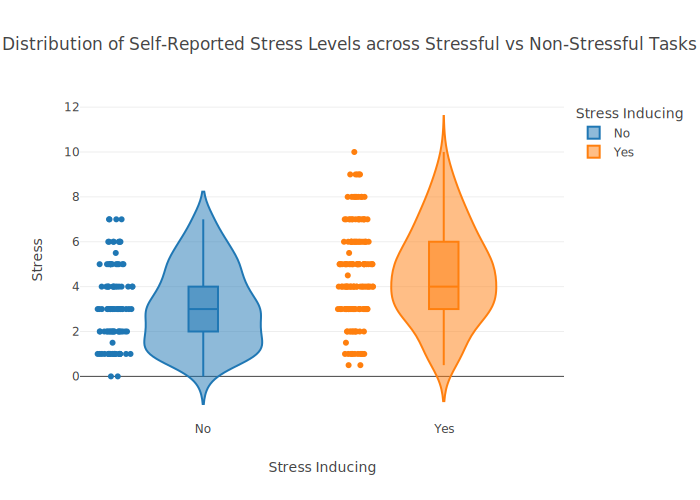

In [12]:
fig = px.violin(
    all_stress,
    x="Stress Inducing",
    y="Stress",
    color="Stress Inducing",
    box = True,
    points="all",
    title="Distribution of Self-Reported Stress Levels across Stressful vs Non-Stressful Tasks"
)
fig.show(renderer="svg")

/Users/essiecheng/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



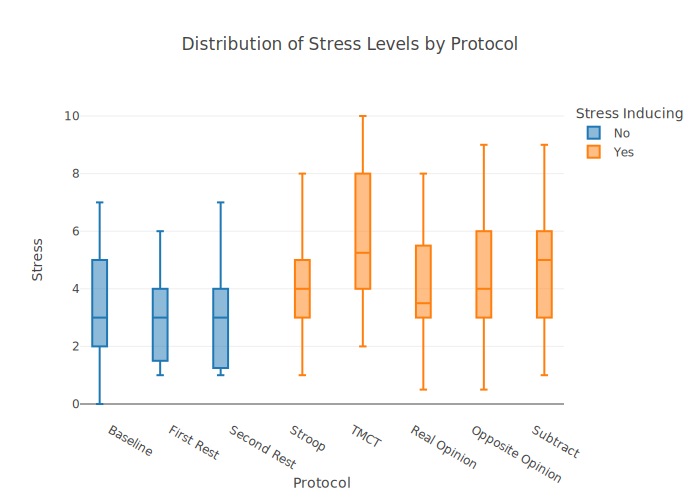

In [13]:
fig = px.box(
    all_stress,
    x="Protocol",
    y="Stress",
    color="Stress Inducing",
    title="Distribution of Stress Levels by Protocol"
)
fig.show(renderer="svg")


It appears stress levels are consistently higher for stress inducing tasks

# Physiological Signals

### Load Data (adapted from Wearable_Dataset.ipynb)
Helper functions

In [14]:
def create_df_array(dataframe):
    """Converts a pandas DataFrame to a flattened numpy array."""
    return dataframe.values.flatten()


def time_abs_(UTC_array):
    """Converts UTC timestamps to seconds from the start of recording."""
    new_array = []
    start_time = datetime.datetime.strptime(UTC_array[0], '%Y-%m-%d %H:%M:%S')
    
    for utc in UTC_array:
        current_time = datetime.datetime.strptime(utc, '%Y-%m-%d %H:%M:%S')
        seconds_elapsed = (current_time - start_time).total_seconds()
        new_array.append(int(seconds_elapsed))
    
    return new_array


def moving_average(acc_data):
    """
    Applies a moving average filter to accelerometer data to measure movement.
    Higher values = more movement, Lower values = less movement
    """
    avg = 0
    prevX, prevY, prevZ = 0, 0, 0
    results = []
    
    # Process every second (32 samples at 32 Hz)
    for i in range(0, len(acc_data), 32):
        sum_ = 0
        buffX = acc_data[i:i+32, 0]
        buffY = acc_data[i:i+32, 1]
        buffZ = acc_data[i:i+32, 2]
        
        for j in range(len(buffX)):
            sum_ += max(
                abs(buffX[j] - prevX),
                abs(buffY[j] - prevY),
                abs(buffZ[j] - prevZ)
            )
            prevX, prevY, prevZ = buffX[j], buffY[j], buffZ[j]
        
        avg = avg * 0.9 + (sum_ / 32) * 0.1
        results.append(avg)
    
    return results

Read & process physiological signals from all subject folders

In [15]:
def read_signals(main_folder):
    """
    Each subject folder contains: EDA, BVP, HR, IBI, TEMP, ACC, tags
    """
    signal_dict = {}
    time_dict = {}
    fs_dict = {}
    
    subfolders = next(os.walk(main_folder))[1]
    
    # Get start times
    utc_start_dict = {}
    for folder_name in subfolders:
        csv_path = f'{main_folder}/{folder_name}/EDA.csv'
        df = pd.read_csv(csv_path)
        utc_start_dict[folder_name] = df.columns.tolist()
    
    # Read all signals
    for folder_name in subfolders:
        folder_path = os.path.join(main_folder, folder_name)
        files = os.listdir(folder_path)
        
        signals = {}
        time_line = {}
        fs_signal = {}
        
        desired_files = ['EDA.csv', 'BVP.csv', 'HR.csv', 'TEMP.csv', 'tags.csv', 'ACC.csv', 'IBI.csv']
        
        for file_name in files:
            if file_name not in desired_files:
                continue
            
            file_path = os.path.join(folder_path, file_name)
            signal_name = file_name.replace('.csv', '')
            
            if file_name == 'tags.csv':
                try:
                    df = pd.read_csv(file_path, header=None)
                    tags_vector = create_df_array(df)
                    tags_UTC_vector = np.insert(tags_vector, 0, utc_start_dict[folder_name])
                    signal_array = time_abs_(tags_UTC_vector)
                except pd.errors.EmptyDataError:
                    signal_array = []
            
            elif file_name == 'IBI.csv':
                df = pd.read_csv(file_path)
                signal_array = df.values
                fs_signal['IBI'] = 'variable'
            
            else:
                df = pd.read_csv(file_path)
                fs = int(df.iloc[0, 0])
                signal_array = df.iloc[1:].values
                time_array = np.linspace(0, len(signal_array)/fs, len(signal_array))
                
                time_line[signal_name] = time_array
                fs_signal[signal_name] = fs
            
            signals[signal_name] = signal_array
        
        signal_dict[folder_name] = signals
        time_dict[folder_name] = time_line
        fs_dict[folder_name] = fs_signal
    
    return signal_dict, time_dict, fs_dict

In [16]:
signal_data, time_data, fs_dict = read_signals(dataset_path)

subjects = list(signal_data.keys())
v1_subjects = sorted([s for s in subjects if s.startswith('S')])
v2_subjects = sorted([s for s in subjects if s.startswith('f')])

print(f"\n✓ Loaded {len(subjects)} subjects:")
print(f"   V1: {v1_subjects}")
print(f"   V2: {v2_subjects}")


✓ Loaded 22 subjects:
   V1: ['S04', 'S05', 'S08', 'S09', 'S10', 'S13', 'S14', 'S15', 'S17', 'S18']
   V2: ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f08', 'f09', 'f10', 'f11', 'f12', 'f13']


### Calculate Biomarkers (adapted from Camille)

In [20]:
def get_stress_rest_segments(subject_id, tags):
    """
    V1: Baseline(R) → Stroop(S) → Rest(R) → TMCT(S) → Rest(R) → Speeches(S) → Subtract(S)
    V2: Baseline(R) → TMCT(S) → Rest(R) → Speeches(S) → Rest(R) → Subtract(S)
    """
    segments = []
    
    if subject_id.startswith('S'):  # V1 protocol
        if len(tags) >= 13:
            segments.append({'start': tags[0], 'end': tags[3], 'label': 'REST', 'phase': 'Baseline'})
            segments.append({'start': tags[3], 'end': tags[4], 'label': 'STRESS', 'phase': 'Stroop'})
            segments.append({'start': tags[4], 'end': tags[5], 'label': 'REST', 'phase': 'First Rest'})
            segments.append({'start': tags[5], 'end': tags[6], 'label': 'STRESS', 'phase': 'TMCT'})
            segments.append({'start': tags[6], 'end': tags[7], 'label': 'REST', 'phase': 'Second Rest'})
            segments.append({'start': tags[7], 'end': tags[8], 'label': 'STRESS', 'phase': 'Real Opinion'})
            segments.append({'start': tags[8], 'end': tags[9], 'label': 'REST', 'phase': 'Transition Rest 1'})  # NEW!
            segments.append({'start': tags[9], 'end': tags[10], 'label': 'STRESS', 'phase': 'Opposite Opinion'})
            segments.append({'start': tags[10], 'end': tags[11], 'label': 'REST', 'phase': 'Transition Rest 2'})  # NEW!
            segments.append({'start': tags[11], 'end': tags[12], 'label': 'STRESS', 'phase': 'Subtract'})
    
    else:  # V2 protocol
        if len(tags) >= 10:
            segments.append({'start': tags[0], 'end': tags[2], 'label': 'REST', 'phase': 'Baseline'})
            segments.append({'start': tags[2], 'end': tags[3], 'label': 'STRESS', 'phase': 'TMCT'})
            segments.append({'start': tags[3], 'end': tags[4], 'label': 'REST', 'phase': 'First Rest'})
            segments.append({'start': tags[4], 'end': tags[5], 'label': 'STRESS', 'phase': 'Real Opinion'})
            segments.append({'start': tags[5], 'end': tags[6], 'label': 'REST', 'phase': 'Transition Rest'})  # NEW!
            segments.append({'start': tags[6], 'end': tags[7], 'label': 'STRESS', 'phase': 'Opposite Opinion'})
            segments.append({'start': tags[7], 'end': tags[8], 'label': 'REST', 'phase': 'Second Rest'})
            segments.append({'start': tags[8], 'end': tags[9], 'label': 'STRESS', 'phase': 'Subtract'})
    
    return segments


In [21]:
all_segments = {}
for subject in subjects:
    tags = signal_data[subject]['tags']
    if len(tags) > 0:
        segments = get_stress_rest_segments(subject, tags)
        all_segments[subject] = segments

print(f"Created segments for {len(all_segments)} subjects\n")
print(f"Ex: - {subjects[0]}:")
for seg in all_segments[subjects[0]]:
    dur = seg['end'] - seg['start']
    print(f"  {seg['label']:7s} {seg['phase']:20s} {seg['start']:4d}-{seg['end']:4d}s ({dur}s)")

Created segments for 22 subjects

Ex: - S05:
  REST    Baseline                0- 478s (478s)
  STRESS  Stroop                478- 590s (112s)
  REST    First Rest            590- 926s (336s)
  STRESS  TMCT                  926-1095s (169s)
  REST    Second Rest          1095-1322s (227s)
  STRESS  Real Opinion         1322-1356s (34s)
  REST    Transition Rest 1    1356-1417s (61s)
  STRESS  Opposite Opinion     1417-1448s (31s)
  REST    Transition Rest 2    1448-1493s (45s)
  STRESS  Subtract             1493-1525s (32s)


In [22]:
def calculate_hrv(ibi_data, start_time, end_time):
    """Calculate HRV: Lower HRV = More Stress"""
    if len(ibi_data) == 0:
        return {'SDNN': np.nan, 'RMSSD': np.nan}
    # 1. Filter IBI data for the time segment
    timestamps = ibi_data[:, 0]
    ibi_values = ibi_data[:, 1]
    mask = (timestamps >= start_time) & (timestamps <= end_time)
    segment_ibi = ibi_values[mask]
    
    if len(segment_ibi) < 2:
        return {'SDNN': np.nan, 'RMSSD': np.nan}
    # 2. Calculate SDNN (Standard Deviation of NN intervals)
    sdnn = np.std(segment_ibi)
    # 3. Calculate RMSSD (Root Mean Square of Successive Differences)
    rmssd = np.sqrt(np.mean(np.diff(segment_ibi)**2)) # Short-term HRV
    
    return {'SDNN': sdnn, 'RMSSD': rmssd}

In [23]:
def extract_segment_features(subject, segment, signals, fs_dict):
    """Extract all biomarkers for one segment"""
    features = {
        'subject': subject,
        'label': segment['label'],
        'phase': segment['phase'],
        'duration': segment['end'] - segment['start']
    }
    
    start_t, end_t = segment['start'], segment['end']
    
    # HRV
    if 'IBI' in signals and len(signals['IBI']) > 0:
        hrv = calculate_hrv(signals['IBI'], start_t, end_t)
        features.update(hrv)
    else:
        features.update({'SDNN': np.nan, 'RMSSD': np.nan})
    
    # EDA
    if 'EDA' in signals:
        fs = fs_dict[subject]['EDA']
        idx_start, idx_end = int(start_t * fs), int(end_t * fs)
        eda = signals['EDA'][idx_start:idx_end].flatten()
        features['EDA_mean'] = np.mean(eda)
        features['EDA_std'] = np.std(eda)
        features['EDA_max'] = np.max(eda)
    
    # HR
    if 'HR' in signals:
        fs = fs_dict[subject]['HR']
        idx_start, idx_end = int(start_t * fs), int(end_t * fs)
        hr = signals['HR'][idx_start:idx_end].flatten()
        features['HR_mean'] = np.mean(hr)
        features['HR_std'] = np.std(hr)
        features['HR_max'] = np.max(hr)
    
    # Temperature
    if 'TEMP' in signals:
        fs = fs_dict[subject]['TEMP']
        idx_start, idx_end = int(start_t * fs), int(end_t * fs)
        temp = signals['TEMP'][idx_start:idx_end].flatten()
        features['TEMP_mean'] = np.mean(temp)
        features['TEMP_std'] = np.std(temp)
    
    # Accelerometer
    if 'ACC' in signals:
        fs = fs_dict[subject]['ACC']
        idx_start, idx_end = int(start_t * fs), int(end_t * fs)
        acc = signals['ACC'][idx_start:idx_end]
        acc_filtered = moving_average(acc)
        features['ACC_mean'] = np.mean(acc_filtered)
        features['ACC_std'] = np.std(acc_filtered)
    
    return features

In [24]:
all_features = []

for subject in subjects:
    if subject in all_segments:
        for segment in all_segments[subject]:
            feat = extract_segment_features(subject, segment, signal_data[subject], fs_dict)
            all_features.append(feat)

df_features = pd.DataFrame(all_features)

print(f"\n✓ Extracted {len(df_features)} segments")
print(f"   STRESS: {len(df_features[df_features['label']=='STRESS'])}")
print(f"   REST: {len(df_features[df_features['label']=='REST'])}")
print(f"\nColumns: {list(df_features.columns)}")
df_features.head()


✓ Extracted 196 segments
   STRESS: 98
   REST: 98

Columns: ['subject', 'label', 'phase', 'duration', 'SDNN', 'RMSSD', 'EDA_mean', 'EDA_std', 'EDA_max', 'HR_mean', 'HR_std', 'HR_max', 'TEMP_mean', 'TEMP_std', 'ACC_mean', 'ACC_std']


,subject,label,phase,duration,SDNN,RMSSD,EDA_mean,EDA_std,EDA_max,HR_mean,HR_std,HR_max,TEMP_mean,TEMP_std,ACC_mean,ACC_std
0,S05,REST,Baseline,478,0.073019,0.047788,9.869496,2.915112,14.756209,82.979079,20.594509,140.83,33.398577,0.088795,2.353354,2.204897
1,S05,STRESS,Stroop,112,0.049038,0.039729,15.573678,0.637616,16.784525,73.815714,2.980611,79.35,33.579643,0.060237,0.692910,0.222790
2,S05,REST,First Rest,336,0.066626,0.051433,18.587111,1.860067,20.730267,72.437827,5.380933,83.63,33.509226,0.064527,1.757452,1.276230
3,S05,STRESS,TMCT,169,0.075088,0.031882,12.581445,0.682693,15.209964,80.628757,4.186074,87.63,33.648994,0.080145,0.740450,0.217494
4,S05,REST,Second Rest,227,0.069203,0.053553,13.969749,0.600660,15.036994,67.476388,2.225019,74.75,33.742026,0.018921,1.536966,0.726953


## Statistical Tests

### Male vs Female HRV

In [33]:
male = df_features[df_features["subject"].str.startswith("S")]["SDNN"]
female = df_features[df_features["subject"].str.startswith("f")]["SDNN"]

ttest_ind(male, female, nan_policy='omit')

Ttest_indResult(statistic=0.2426692910658246, pvalue=0.8085507313064867)

Male and female participants do not show detectable differences in HRV

### Stress vs Rest HRV

In [43]:
stress = df_features[df_features["label"]=="STRESS"]["SDNN"]
rest = df_features[df_features["label"]=="REST"]["SDNN"]

ttest_rel(stress, rest, nan_policy='omit')

Ttest_relResult(statistic=-2.7796995062299157, pvalue=0.006834702006666621)

HRV is a statistically significant indicator of stress and drops during stressful phases

### Baseline vs TMCT Across Signals

In [44]:
phys = ['SDNN','RMSSD','EDA_mean','HR_mean','TEMP_mean','ACC_mean']

for p in phys:
    a = df_features[df_features["phase"]=="Baseline"][p]
    b = df_features[df_features["phase"]=="TMCT"][p]
    print(p, ttest_rel(a,b))

SDNN Ttest_relResult(statistic=1.4035981051068327, pvalue=0.17505368894639034)
RMSSD Ttest_relResult(statistic=2.4177704341743445, pvalue=0.024791477612041278)
EDA_mean Ttest_relResult(statistic=-0.9352474662853444, pvalue=0.3602917293963447)
HR_mean Ttest_relResult(statistic=-1.999785840481245, pvalue=0.058624824131099935)
TEMP_mean Ttest_relResult(statistic=-1.522180766980987, pvalue=0.14288053092199607)
ACC_mean Ttest_relResult(statistic=2.2805113003595405, pvalue=0.03312487181286207)


It appears: 
- RMSSD and ACC are strong responders to stress
- HR is a moderate responder
- SDNN, EDA, and TEMP are weak responders to stress